# Chapter 3: Classification

In [1]:
import matplotlib.pyplot as plt #type: ignore

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
import sklearn  #type: ignore

In [3]:
from sklearn.datasets import fetch_openml  #type: ignore

mnist = fetch_openml("mnist_784", as_frame=False)

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black)

In [7]:
def reshaper(some_data):
    some_data = some_data.reshape(28, 28)
    return some_data.shape

reshaper(X[0])

(28, 28)

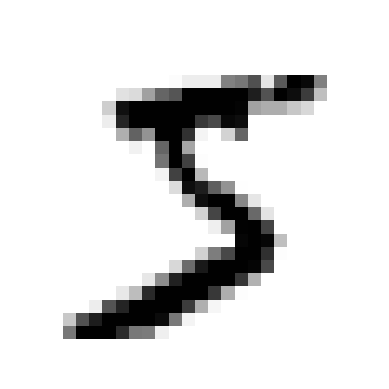

In [8]:
import matplotlib.pyplot as plt #type: ignore

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable
of distinguishing between just two classes, 5 and non-5.

In [11]:
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

SGD Classifier - Stochastic gradient descent

In [12]:
from sklearn.linear_model import SGDClassifier  #type: ignore

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

What we have to understand here is that our data is very skewed

In [13]:
import pandas as pd #type: ignore

pd.Series(y_train_5).value_counts(normalize=True)

False    0.90965
True     0.09035
Name: proportion, dtype: float64

If we would always predict that the image is not a '5' we would get a 90% accuracy!

In [14]:
from sklearn.dummy import DummyClassifier   #type: ignore
from sklearn.model_selection import cross_val_score     #type: ignore

dummy_cld = DummyClassifier()
dummy_cld.fit(X_train, y_train_5)
cross_val_score(dummy_cld, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In cases when our data is that skewed we need to use other metrics

### Confusion Matrices

To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets. You can use the `cross_val_predict()` function

In [15]:
from sklearn.model_selection import cross_val_predict   #type: ignore

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

it returns the predictions
made on each test fold.

In [16]:
from sklearn.metrics import confusion_matrix    #type: ignore

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the
negative class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives, also
called type I errors). The second row considers the images of 5s (the positive class):
1,891 were wrongly classified as non-5s (false negatives, also called type II errors),
while the remaining 3,530 were correctly classified as 5s (true positives).

$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall} = \frac{TP}{TP + FN}$$

In [17]:
from sklearn.metrics import precision_score, recall_score    #type: ignore

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


$$F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [18]:
from sklearn.metrics import f1_score     #type: ignore

f1_score(y_train_5, y_train_pred)

0.7325171197343847

The
F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the
regular mean treats all values equally, the harmonic mean gives much more weight to
low values. As a result, the classifier will only get a high F1 score if both recall and
precision are high.

However in some cases you will care more about precision and in some about recall. Precision is about being afraid to make a mistake - if you want to take action only when absolutely certain you want to have the highest precision (allow children to watch content after verifying it is safe). Or it may be essential to catch all positive cases, while being okay with making bunch of wrong positive predictions (you want to catch every single burglar even at a cost of numerous wrong accusations)

### The Precision/Recall Trade-off (Precision/Recall Curve)

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0

#Threshold upon which classifier decides whether to assign a positive or a negative value

In [21]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 3000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Increasign a threshold means lowering the recall and increasing with precision - we are okay with missing a couple of positives as long as we have not made a mistake with our positive predictions (we don't care about FN, but we are concernced about FP) - better make a mistake than create a FP choice

How do you decide which threshold to use? First, use the `cross_val_predict()`
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:


In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")


In [24]:
from sklearn.metrics import precision_recall_curve   #type: ignore

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [25]:
print(precisions.shape)
print(thresholds.shape)

(60001,)
(60000,)


In [26]:
thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905])

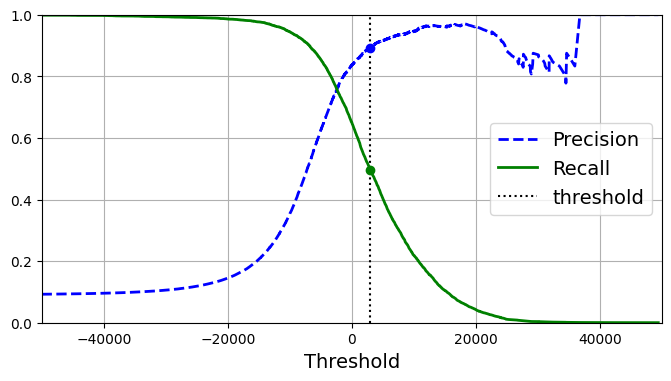

In [27]:
#we use [:-1] to get rid off last element and 
# make precisions, recall and thresholds all equal to 60000

plt.figure(figsize=(8,4))
plt.plot(thresholds, precisions[:-1],"b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

#For design
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

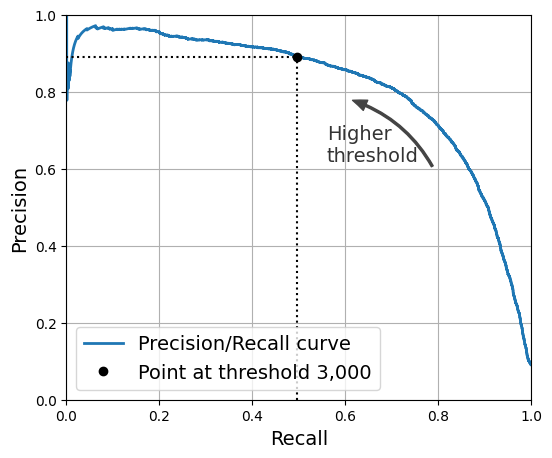

In [28]:
import matplotlib.patches as patches  # extra code – for the curved arrow    #type: ignore

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

#For design!
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Suppose you want to find the lowest threshold to give you 90% precision

We find the index of the first precision >= 90 in precisions and we use that index to get the threshold which gurantees us that precision

In [29]:
index_90 = (precisions >= 0.90).argmax()
threshold_90 = thresholds[index_90]
threshold_90

3370.0194991439557

We take the decision function and create a boolean array to highlight what indexes should be classified as positives and which as negatives

In [30]:
y_train_pred_90 = (y_scores >= threshold_90)
y_train_pred_90.shape

(60000,)

Finally we calculate the precision

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

However the recall is low

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR).

In [33]:
from sklearn.metrics import roc_curve    #type: ignore

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

To find the point that corresponds to 90% precision,
we need to look for the index of the desired threshold. Since thresholds are listed in
decreasing order in this case, we use <= instead of >= on the first line:

In [34]:
index_for_90 = (thresholds <= threshold_90).argmax()
fpr_90 = fpr[index_for_90]
tpr_90 = tpr[index_for_90]

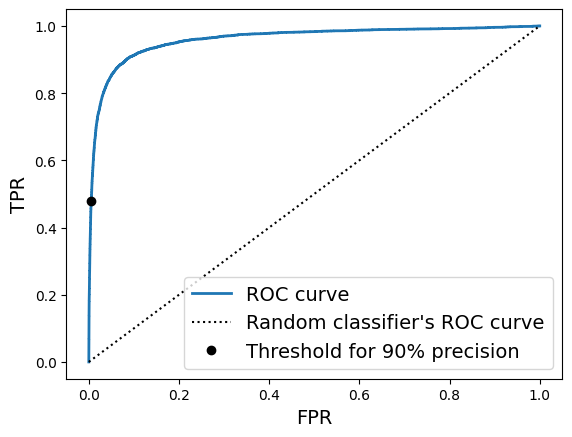

In [35]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0, 1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A
perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier
will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the
ROC AUC:

In [36]:
from sklearn.metrics import roc_auc_score    #type: ignore

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example,
looking at the previous ROC curve (and the ROC AUC score),
you may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement: the curve could really be closer to the
top-right corner (see Figure 3-6 again).

## Multiclass Classification

Can distinguish between more than two classes

Some Scikit-Learn classifiers (e.g., LogisticRegression, RandomForestClassifier,
and GaussianNB) are capable of handling multiple classes natively. Others are strictly
binary classifiers (e.g., SGDClassifier and SVC).

**One-vs-all / One-vs-rest**

One way to create a system that can classify the digit images into 10 classes (from 0
to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a
2-detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier
outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or
sometimes one-versus-all (OvA).

**One-vs-one**

Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so
on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need
to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training
45 binary classifiers! When you want to classify an image, you have to run the
image through all 45 classifiers and see which class wins the most duels. The main
advantage of OvO is that each classifier only needs to be trained on the part of the
training set containing the two classes that it must distinguish.

>Some algorithms (such as support vector machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large
training sets. For most binary classification algorithms, however, OvR is preferred.

>Scikit-Learn detects when you try to use a binary classification algorithm for a
multiclass classification task, and it automatically runs OvR or OvO, depending
on the algorithm.

In [37]:
from sklearn.svm import SVC      #type: ignore

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

>Scikit-Learn used the OvO strategy and trained 45
binary classifiers.

In [38]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That’s correct! This code actually made 45 predictions—one per pair of classes—and
it selected the class that won the most duels. If you call the `decision_function()`
method, you will see that it returns 10 scores per instance: one per class. Each class
gets a score equal to the number of won duels plus or minus a small tweak (max
±0.33) to break ties, based on the classifier scores:

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [40]:
class_id = some_digit_scores.argmax()
class_id
#in this case index and the actual class match each other,
# but that won't always be the case

5

When a classifier is trained, it stores the list of target classes in its `classes_` attribute,
ordered by value. In the case of MNIST, the index of each class in the `classes_` array
conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'),
but in general you won’t be so lucky; you will need to look up the class label like this:

In [41]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

> If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes.

In [42]:
from sklearn.multiclass import OneVsRestClassifier       #type: ignore

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [43]:
len(ovr_clf.estimators_)

10

**SGD Classifier**

In [44]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Oops, that’s incorrect. Prediction errors do happen! This time Scikit-Learn used
the OvR strategy under the hood

In [45]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
from sklearn.preprocessing import StandardScaler         #type: ignore

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled[:10000], y_train[:10000],
                 cv=3, scoring="accuracy")

c:\Users\ANDREY\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89172166, 0.90939094, 0.8889889 ])

## Error Analysis

In [48]:
plt.figure(figsize=(12, 8), dpi=300)

from sklearn.metrics import ConfusionMatrixDisplay       #type: ignore

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay(y_train, y_train_pred,
                        normalize="true", values_format=".0%")
plt.show()

TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'normalize'

<Figure size 3600x2400 with 0 Axes>

> THERE ARE OTHER MATRIXES BUT I DID NOT PRODUCE THEM CAUSE OF HOW LONG IT TAKES

## Multilabel Classification

Until now, each instance has always been assigned to just one class. But in some cases
you may want your classifier to output multiple classes for each instance.

In [ ]:
import numpy as np   #type: ignore
from sklearn.neighbors import KNeighborsClassifier      #type: ignore

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
y_multilabel[:5]

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9), and the second
indicates whether or not it is odd. Then the code creates a KNeighborsClassifier
instance, which supports multilabel classification (not all classifiers do), and trains
this model using the multiple targets array.


>- F1 Score: Best for binary classification or when you're interested in the performance of a specific class.
>- Macro F1 Score: Best for multi-class classification when you want to treat all classes equally, even if they are imbalanced.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled,
                                      y_multilabel, cv=3)

f1_score(y_multilabel, y_train_pred, average="macro")

This approach (using macro) assumes that all labels are equally important, which may not be the
case. In particular, if you have many more pictures of Alice than of Bob or Charlie,
you may want to give more weight to the classifier’s score on pictures of Alice. One
simple option is to give each label a weight equal to its support (i.e., the number of
instances with that target label). To do this, simply set average="weighted" when
calling the f1_score() function.5

## Multioutput Classification

It is a generalization of multilabel
classification where each label can be multiclass (i.e., it can have more than two
possible values).

In [ ]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [ ]:
y_train = X_train
y_test = X_test

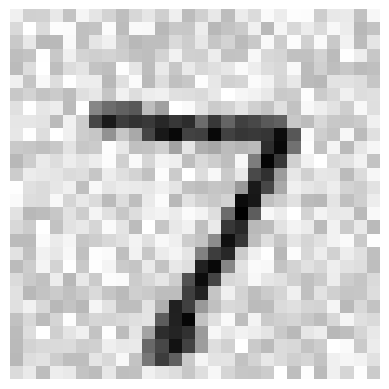

In [ ]:
plot_digit(X_test_mod[0])
plt.show()

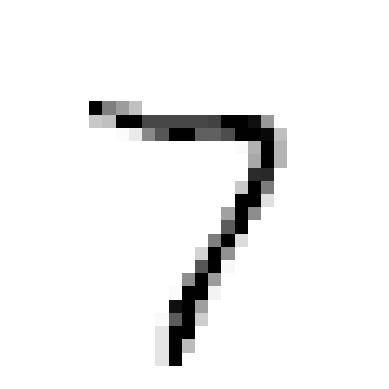

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_mod, y_train)

clean_digit = knn.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

## Implementing Cross-Validation